In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241119)
np.random.seed(20241119)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [2]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="稳定运行数据段")
units=df_whole.iloc[0].tolist()
df=df_whole.iloc[2:].reset_index(drop=True)

df.columns=[ # 重命名列名
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]

var_dict={
    "主蒸汽流量计算值": "t/h",
    "烟气含氧量（CEMS）": "mg/Nm3",
    "NO浓度": "mg/Nm3",
    "NO2浓度": "mg/Nm3",
    "NOX浓度": "mg/Nm3",
    "烟气湿度（CEMS）": "%",
    "烟气压力（CEMS）": "Pa",
    "烟气温度（CEMS）": "℃",
    "一氧化碳": "mg/Nm3",
    "锅炉天然气进气流量": "m3/h",
    "锅炉天然气进气温度": "℃",
    "锅炉天然气进气压力": "kPa",
    '鼓风机出口温度': "℃",
    "鼓风机出口压力": "kPa",
    "鼓风机变频器输出反馈": "Hz",
    "鼓风机变频器电流反馈": "A",
    "冷凝器出口烟气调节阀反馈": "%",
    "炉膛出口烟气压力": "Pa",
    "SWY大气压": "kPa",
    "SWY天气温度": "℃",
    "SWY空气湿度": "%",
    'SWY湿球温度': "℃",
    '主蒸汽温度(蒸汽集箱出口温度）': "℃",
    "主蒸汽压力(蒸汽集箱出口压力）": "MPa",
    "分汽缸温度": "℃",
    "分汽缸压力": "MPa",
    '分汽缸出口至DN400蒸汽温度': "℃",
    '过热器集箱出口蒸汽温度': "℃",
    "冷凝器出口烟气流量": "Nm3/h",
    "冷凝器出口烟气温度": "℃",
}


var_names=list(var_dict.keys())
var_units=list(var_dict.values())

data_np=df[var_names].to_numpy(dtype=float)
DATA=[ # 通过不同切片增加数据量
    data_np,
    data_np[:800,:],
    data_np[100:850,:],
    data_np[200:900,:],
    data_np[300:950,:],
    data_np[400:1000,:],
    ]
print(data_np.shape)

(1124, 30)


In [3]:
DATA=[
    data_np,
    data_np[:800,:],
    data_np[100:850,:],
    data_np[200:900,:],
    data_np[300:950,:],
    data_np[400:1000,:],
    ]

In [4]:
from gas_data_prediction.data_preprocessing import time_series_standardization, time_series_split

input_len=1
output_len=1
input_channels=len(var_names)
output_channels=len(var_names)

DATA, var_mean , var_std_dev = time_series_standardization(data=DATA, mode="multiple") # list of numpy arrays of shape (n_timesteps, n_vars)
X, Y, X_grouped, Y_grouped = time_series_split(data=DATA,input_len=input_len, output_len=output_len, mode="multiple")
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("len(X_grouped):", len(X_grouped))
print("len(Y_grouped):", len(Y_grouped))
print("X_grouped[0] shape:", X_grouped[0].shape)
print("Y_grouped[0] shape:", Y_grouped[0].shape)

X shape: (4612, 1, 30)
Y shape: (4612, 1, 30)
len(X_grouped): 6
len(Y_grouped): 6
X_grouped[0] shape: (1122, 1, 30)
Y_grouped[0] shape: (1122, 1, 30)


In [5]:
from models.SVR import SVR, LinearSVR, NuSVR

model=LinearSVR(input_len=input_len, output_len=output_len,input_channels=input_channels, output_channels=output_channels)
model.fit(X[:400],Y[:400])

d:\Anaconda3\envs\env_py312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Anaconda3\envs\env_py312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Anaconda3\envs\env_py312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Anaconda3\envs\env_py312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Anaconda3\envs\env_py312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Anaconda3\envs\env_py312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

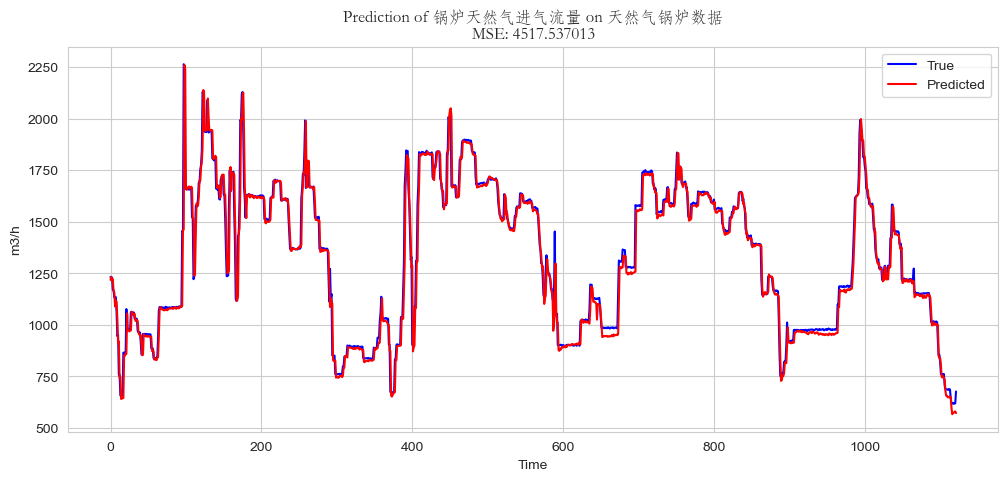

In [13]:
# Visualize on a particular variable and particular file
from gas_data_prediction.utils import visualize_var, get_pred_true_pairs
def visualize_var(Y_pred,Y_true,var_idx,var_names,var_units,
                    data_name="0",
                    var_mean=None,
                    var_std_dev=None,
                    plot_residual=False,
                    rescale=False
                    ):
    '''
    Y_pred: numpy array of shape (n_samples, n_vars)
    Y_true: numpy array of shape (n_samples, n_vars)
    var_idx: index of the variable to be visualized
    
    plot_residual: whether to plot the residual or the actual values
    rescale: whether to rescale the values to their original scale or not
    '''
    assert type(Y_pred)==np.ndarray and Y_pred.ndim==2, "Y_pred should be a 2D numpy array"
    assert type(Y_true)==np.ndarray and Y_true.ndim==2, "Y_true should be a 2D numpy array"
    assert Y_pred.shape==Y_true.shape, "Y_pred and Y_true should have the same shape"
    assert len(var_names)==len(var_units), "var_names and var_units should have the same length"
    assert var_idx in range(len(var_names)), "var_idx should be within the range of var_names"
    assert plot_residual in [True, False], "plot_residual should be either True or False"
    assert rescale in [True, False], "rescale should be either True or False"

    try:
        from matplotlib.font_manager import FontProperties
        font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STFANGSO.ttf", size=14)
        font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STFANGSO.ttf", size=12)
        font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STFANGSO.ttf", size=10)
        font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STFANGSO.ttf", size=7)
    except:
        raise Exception('为了中文的正常显示，请确保您的系统为Windows系统，并安装了STFANGSO.ttf字体。\n通常该字体的路径为"C:\\Windows\\Fonts\\STFANGSO.ttf"')

    y_true=Y_true[:,var_idx] # shape: (n_samples,)
    y_pred=Y_pred[:,var_idx] # shape: (n_samples,)
    y_mean=var_mean[var_idx] # float
    y_std_dev=var_std_dev[var_idx] # float
    plt.figure(figsize=(12,5))
    
    if plot_residual==False:
        if rescale == False:
            plt.plot(y_true,c='b',label='True')
            plt.plot(y_pred,c='r',label='Predicted')
            plt.ylabel("Normalized Value")
        elif rescale == True:
            plt.plot(y_true*y_std_dev+y_mean,c='b',label='True')
            plt.plot(y_pred*y_std_dev+y_mean,c='r',label='Predicted')
            plt.ylabel(var_units[var_idx])
    elif plot_residual==True:
        if rescale == False:
            plt.plot(y_true-y_pred,c='b',label='Residual')
            plt.ylabel("Normalized Value")
        elif rescale == True:
            plt.plot((y_true-y_pred)*y_std_dev,c='b',label='Residual')
            plt.ylabel(var_units[var_idx])

    title_str="Prediction of {} on {}".format(var_names[var_idx],data_name)
    if rescale == False:
        title_str+="\nMSE: {:.6f}".format(((y_true-y_pred)**2).mean())
    elif rescale == True:
        title_str+="\nMSE: {:.6f}".format((((y_true-y_pred)*y_std_dev)**2).mean())
    plt.title(title_str,fontproperties=font2)
    
    plt.xlabel('Time')
    plt.legend()
    plt.show()
var_idx=9
data_idx=0

Y_pred, Y_true=get_pred_true_pairs(model,X_grouped,Y_grouped,data_idx=data_idx)

shared_params={
    'Y_pred': Y_pred,
    'Y_true': Y_true,
    'var_idx': var_idx,
    'var_names': var_names,
    'var_units': var_units,
    'data_name': "天然气锅炉数据",
    'var_mean': var_mean,
    'var_std_dev': var_std_dev,
}


visualize_var(**shared_params, plot_residual=False, rescale=True)